In [1]:
# Required packages, install if not installed (assume PyTorch* and Intel® Extension for PyTorch* is already present)
!echo "Installation in progress..."
# import sys
# !{sys.executable} -m pip install  invisible-watermark > /dev/null
# !conda install -y --quiet --prefix {sys.prefix}  -c conda-forge \
#     accelerate==0.23.0 \
#     validators==0.22.0 \
#     diffusers==0.18.2 \
#     transformers==4.32.1 \
#     tensorboardX \
#     pillow \
#     ipywidgets \
#     ipython > /dev/null && echo "Installation successful" || echo "Installation failed"
import sys
!{sys.executable} -m pip install invisible-watermark --user > /dev/null 2>&1 
!{sys.executable} -m pip install transformers huggingface-hub --user > /dev/null 2>&1
!echo "Installtion complete..."

Installation in progress...
Installtion complete...


In [2]:
from io import BytesIO
import os
import time
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

1
2
3
4
5
6


In [3]:
# Suppress warnings for a cleaner output.
warnings.filterwarnings("ignore")

import random
import requests
import torch
import torch.nn as nn
import intel_extension_for_pytorch as ipex  # adds xpu namespace to PyTorch, enabling you to use Intel GPUs
import validators
import numpy as np

7
8
9
10
11
12
13


In [4]:


from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import DPMSolverMultistepScheduler

import os
import random
import time

import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mp_img
import validators

from IPython.display import clear_output
from IPython.display import display
from IPython.display import HTML
from IPython.display import Image as IPImage
from ipywidgets import VBox, HBox

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from PIL import Image


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [5]:
class Img2ImgModel:
    """
    This class creates a model for transforming images based on given prompts.
    """

    def __init__(
        self,
        model_id_or_path: str,
        device: str = "xpu",
        torch_dtype: torch.dtype = torch.bfloat16,
        optimize: bool = True,
        warmup: bool = False,
        scheduler: bool = True,
    ) -> None:
        """
        Initialize the model with the specified parameters.

        Args:
            model_id_or_path (str): The ID or path of the pre-trained model.
            device (str, optional): The device to run the model on. Defaults to "xpu".
            torch_dtype (torch.dtype, optional): The data type to use for the model. Defaults to torch.float16.
            optimize (bool, optional): Whether to optimize the model. Defaults to True.
        """
        self.device = device
        self.data_type = torch_dtype
        self.scheduler = scheduler
        self.generator = torch.Generator()  # .manual_seed(99)
        self.pipeline = self._load_pipeline(model_id_or_path, torch_dtype)
        if optimize:
            start_time = time.time()
            #print("Optimizing the model...")
            self.optimize_pipeline()
            #print(
            #    "Optimization completed in {:.2f} seconds.".format(
            #        time.time() - start_time
            #    )
            #)
        if warmup:
            self.warmup_model()

    def _load_pipeline(
        self, model_id_or_path: str, torch_dtype: torch.dtype
    ) -> StableDiffusionImg2ImgPipeline:
        """
        Load the pipeline for the model.

        Args:
            model_id_or_path (str): The ID or path of the pre-trained model.
            torch_dtype (torch.dtype): The data type to use for the model.

        Returns:
            StableDiffusionImg2ImgPipeline: The loaded pipeline.
        """
        print("Loading the model...")
        model_path = Path(f"/home/common/data/Big_Data/GenAI/{model_id_or_path}")
        
        if model_path.exists():
            #print(f"Loading the model from {model_path}...")
            load_path = model_path
        else:
            print("Using the default path for models...")
            load_path = model_id_or_path
            
        pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
            load_path,
            torch_dtype=torch_dtype,
            use_safetensors=True,
            variant="fp16",
        )
        if self.scheduler:
            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config
            )
        if not model_path.exists():
            try:
                print(f"Attempting to save the model to {model_path}...")
                pipeline.save_pretrained(f"{model_path}")
                print("Model saved.")
            except Exception as e:
                print(f"An error occurred while saving the model: {e}. Proceeding without saving.")
        pipeline = pipeline.to(self.device)
        #print("Model loaded.")
        return pipeline

    def _optimize_pipeline(
        self, pipeline: StableDiffusionImg2ImgPipeline
    ) -> StableDiffusionImg2ImgPipeline:
        """
        Optimize the pipeline of the model.

        Args:
            pipeline (StableDiffusionImg2ImgPipeline): The pipeline to optimize.

        Returns:
            StableDiffusionImg2ImgPipeline: The optimized pipeline.
        """
        for attr in dir(pipeline):
            if isinstance(getattr(pipeline, attr), nn.Module):
                setattr(
                    pipeline,
                    attr,
                    ipex.optimize(
                        getattr(pipeline, attr).eval(),
                        dtype=pipeline.text_encoder.dtype,
                        inplace=True,
                    ),
                )
        return pipeline

    def optimize_pipeline(self) -> None:
        """
        Optimize the pipeline of the model.
        """
        self.pipeline = self._optimize_pipeline(self.pipeline)

    def get_image_from_url(self, url: str, path: str) -> Image.Image:
        """
        Get an image from a URL or from a local path if it exists.

        Args:
            url (str): The URL of the image.
            path (str): The local path of the image.

        Returns:
            Image.Image: The loaded image.
        """
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(
                f"Failed to download image. Status code: {response.status_code}"
            )
        if not response.headers["content-type"].startswith("image"):
            raise Exception(
                f"URL does not point to an image. Content type: {response.headers['content-type']}"
            )
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(path)
        img = img.resize((768, 512))
        return img

    def warmup_model(self):
        """
        Warms up the model by generating a sample image.
        """
        print("Setting up model...")
        start_time = time.time()
        image_url = "https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png"
        try:
            self.generate_images(
                image_url=image_url,
                prompt="A beautiful day",
                num_images=1,
                save_path=".tmp",
            )
        except Exception:
            print("model warmup delayed...")
        #print(
        #    "Model is set up and ready! Warm-up completed in {:.2f} seconds.".format(
        #        time.time() - start_time
        #    )
        #)

    def get_inputs(self, prompt, batch_size=1):
        self.generator = [torch.Generator() for i in range(batch_size)]
        prompts = batch_size * [prompt]
        return {"prompt": prompts, "generator": self.generator}

    def generate_images(
        self,
        prompt: str,
        image_url: str,
        num_images: int = 5,
        num_inference_steps: int = 30,
        strength: float = 0.75,
        guidance_scale: float = 7.5,
        save_path: str = "image_to_image",
        batch_size: int = 1,
    ):
        """
        Generate images based on the provided prompt and variations.

        Args:
            prompt (str): The base prompt for the generation.
            image_url (str): The URL of the seed image.
            variations (List[str]): The list of variations to apply to the prompt.
            num_images (int, optional): The number of images to generate. Defaults to 5.
            num_inference_steps (int, optional): Number of noise removal steps.
            strength (float, optional): The strength of the transformation. Defaults to 0.75.
            guidance_scale (float, optional): The scale of the guidance. Defaults to 7.5.
            save_path (str, optional): The path to save the generated images. Defaults to "image_to_image".

        """
        input_image_path = "input.png"
        init_image = self.get_image_from_url(image_url, input_image_path)
        init_images = [init_image for _ in range(batch_size)]
        for i in range(0, num_images, batch_size):
            with torch.xpu.amp.autocast(
                enabled=True if self.data_type != torch.float32 else False,
                dtype=self.data_type,
            ):
                if batch_size > 1:
                    inputs = self.get_inputs(batch_size=batch_size, prompt=prompt)
                    images = self.pipeline(
                        **inputs,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images
                else:
                    images = self.pipeline(
                        prompt=prompt,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images

                for j in range(len(images)):
                    output_image_path = os.path.join(
                        save_path,
                        f"{'_'.join(prompt.split()[:3])}_{i+j}__{int(time.time() * 1e6)}.png",
                    )
                    images[j].save(output_image_path)
                    
    def generate_image(
        self,
        prompt: str,
        image: Image.Image,
        num_images: int = 5,
        num_inference_steps: int = 30,
        strength: float = 0.75,
        guidance_scale: float = 7.5,
        save_path: str = "image_to_image",
        batch_size: int = 1,
    ):
        """
        Generate images based on the provided prompt and variations.

        Args:
            prompt (str): The base prompt for the generation.
            image_url (str): The URL of the seed image.
            variations (List[str]): The list of variations to apply to the prompt.
            num_images (int, optional): The number of images to generate. Defaults to 5.
            num_inference_steps (int, optional): Number of noise removal steps.
            strength (float, optional): The strength of the transformation. Defaults to 0.75.
            guidance_scale (float, optional): The scale of the guidance. Defaults to 7.5.
            save_path (str, optional): The path to save the generated images. Defaults to "image_to_image".

        """
        init_image = image
        init_images = [init_image for _ in range(batch_size)]
        out = []
        for i in range(0, num_images, batch_size):
            with torch.xpu.amp.autocast(
                enabled=True if self.data_type != torch.float32 else False,
                dtype=self.data_type,
            ):
                if batch_size > 1:
                    inputs = self.get_inputs(batch_size=batch_size, prompt=prompt)
                    images = self.pipeline(
                        **inputs,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images
                else:
                    images = self.pipeline(
                        prompt=prompt,
                        image=init_images,
                        strength=strength,
                        guidance_scale=guidance_scale,
                        num_inference_steps=num_inference_steps,
                    ).images

                for j in range(len(images)):
                    output_image_path = os.path.join(
                        save_path,
                        f"{'_'.join(prompt.split()[:3])}_{i+j}__{int(time.time() * 1e6)}.png",
                    )
                    out.append(images[j])
        return out



model_cache = {}

def image_to_image():
    out = widgets.Output()
    image_to_image_dir = "image_to_image"
    num_images = 2
    model_ids = [
        "runwayml/stable-diffusion-v1-5",
        "stabilityai/stable-diffusion-2-1",
    ]    
    model_dropdown = widgets.Dropdown(
        options=model_ids,
        value=model_ids[0],
        description="Model:",
    )    
    prompt_text = widgets.Text(
        value="",
        placeholder="Enter your prompt",
        description="Prompt:",
    )    
    num_images_slider = widgets.IntSlider(
        value=2,
        min=1,
        max=10,
        step=1,
        description="Images:",
    )    
    image_url_text = widgets.Text(
        value="https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png",
        placeholder="Enter an image URL",
        description="Image URL:",
    )
    enhance_checkbox = widgets.Checkbox(
        value=False,
        description="Auto enhance the prompt?",
        disabled=False,
        indent=False
    )
    enhance_checkbox.layout.margin = "0 0 0 10px"
    num_images_slider.layout.margin = "0 0 0 8px"
    prompt_text.layout.width = "100%"
    layout = widgets.Layout(margin="0px 50px 10px 0px")
    button = widgets.Button(description="Generate Images!", button_style="primary")
    left_box = VBox([model_dropdown,num_images_slider], layout=layout)
    right_box = VBox([image_url_text, enhance_checkbox], layout=layout)
    user_input_widgets = HBox([left_box, right_box], layout=layout)
    prompt_text.layout.width = "57.5%"
    button.layout.margin = "35px"
    display(user_input_widgets)
    display( prompt_text)
    display(button)
    display(out)
    
    
    def on_submit(button):
        with out:
            clear_output(wait=True)
            print("Once generated, images will be saved to `./image_to_image` dir, please wait...")
            selected_model_index = model_ids.index(model_dropdown.value)
            model_id = model_ids[selected_model_index]
            model_key = (model_id, "xpu")
            prompt = prompt_text.value
            num_images = num_images_slider.value
            image_url = image_url_text.value
            
            if not validators.url(image_url):
                print("The input is not a valid URL. Using the default URL instead.")
                image_url = "https://user-images.githubusercontent.com/786476/256401499-f010e3f8-6f8d-4e9f-9d1f-178d3571e7b9.png"       
            #model = Img2ImgModel(model_id, device="xpu")
            if model_key not in model_cache:
                model_cache[model_key] = Img2ImgModel(model_id, device="xpu")
            model = model_cache[model_key]
            enhancements = [
            "purple light",
            "dreaming",
            "cyberpunk",
            "ancient" ", rustic",
            "gothic",
            "historical",
            "punchy",
            "photo" "vivid colors",
            "4k",
            "bright",
            "exquisite",
            "painting",
            "art",
            "fantasy [,/organic]",
            "detailed",
            "trending in artstation fantasy",
            "electric",
            "night",
            ]
            if not prompt:
                prompt = " "
            if enhance_checkbox.value:
                prompt = prompt + " " + " ".join(random.sample(enhancements, 5))
                print(f"Using enhanced prompt: {prompt}")    
            try:
                start_time = time.time()
                os.makedirs(image_to_image_dir, exist_ok=True)
                model.generate_images(
                    prompt=prompt,
                    image_url=image_url,
                    num_images=num_images,
                )
                clear_output(wait=True)
                display_generated_images()
            except KeyboardInterrupt:
                print("\nUser interrupted image generation...")
            except Exception as e:
                print(f"An error occurred: {e}")
            finally:
                status = f"Complete generating {num_images} images in {time.time() - start_time:.2f} seconds."
                #print(status)
    button.on_click(on_submit)

def display_generated_images(image_to_image_dir="image_to_image"):
    image_files = [f for f in os.listdir(image_to_image_dir) if f.endswith((".png", ".jpg"))]    
    num_images = len(image_files)
    num_columns = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.ceil(num_images / num_columns))
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10 * num_columns / num_columns, 10 * num_rows / num_rows))
    if num_images == 1:
        axs = np.array([[axs]])
    elif num_columns == 1 or num_rows == 1:
        axs = np.array([axs])
    for ax, image_file in zip(axs.ravel(), image_files):
        img = mp_img.imread(os.path.join(image_to_image_dir, image_file))
        ax.imshow(img)
        ax.axis("off")
    for ax in axs.ravel()[num_images:]:
        ax.axis("off")
    plt.tight_layout()
    print(f"\nGenerated images...:")
    plt.show()

asdasd


In [6]:
BASE_PROMPT = "Image of a <INPUT>"
model_id = "stabilityai/stable-diffusion-2-1"
modell = Img2ImgModel(model_id, device="xpu")

def generate_additional_images(image, className, n=1):
    prompt = BASE_PROMPT.replace("<INPUT>", className)
    return modell.generate_image(prompt, image, n)

    
url = r"https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-10T23%3A17%3A55.324Z?alt=media&token=6143c912-d0e4-4c7f-b882-2391adb653a1."
img = modell.get_image_from_url(url, "img.png")
output = generate_additional_images(img, "Sattelite Shot of Wildfire", 10)

Loading the model...


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

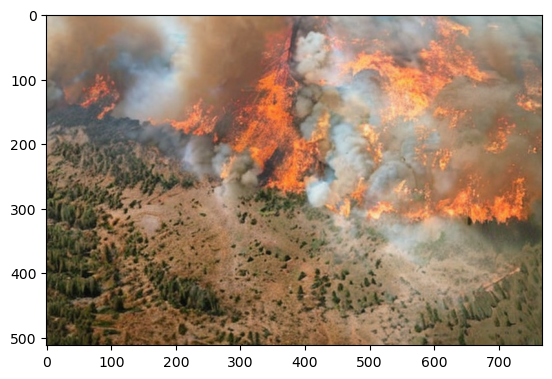

In [7]:
plt.imshow(output[2])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np

class VGG16Settings():
    NUM_PREDICTION_CLASSES = None
    HIDDEN_UNITS = 10
    TRAIN_EPOCHS = 10
    LR = .01
    BATCH_SIZE = 32
    DEVICE = "xpu"

class BaseModel():
    def __init__(settings):
        pass
    def train_model():
        pass
    def classify():
        pass
        
class VGG16():
    def __init__(self, settings : VGG16Settings):
        vgg16 = models.vgg16(pretrained=True)

        for param in vgg16.features.parameters():
            param.requires_grad = False

        num_features = vgg16.classifier[0].in_features
        vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, settings.HIDDEN_UNITS),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(settings.HIDDEN_UNITS, settings.NUM_PREDICTION_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        self.settings = settings
        self.model = vgg16

    def train_model(self, inputs, targets):
        
        #BOB's suggestion
        train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        inputs_transformed = [train_transforms(input).unsqueeze(0) for input in inputs]
        inputs_tensor = torch.cat(inputs_transformed, dim=0)
        targets_tensor = torch.tensor(targets, dtype=torch.long)

        dataset = TensorDataset(inputs_tensor, targets_tensor)
        train_loader = DataLoader(dataset, batch_size=self.settings.BATCH_SIZE, shuffle=True)

        self.model.to(self.settings.DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.settings.LR)

        self.model.train()
        losses = []
        for epoch in range(self.settings.TRAIN_EPOCHS):
            total_loss = 0
            for batch_inputs, batch_targets in train_loader:
                batch_inputs, batch_targets = batch_inputs.to(self.settings.DEVICE), batch_targets.to(self.settings.DEVICE)

                optimizer.zero_grad()
                outputs = self.model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss/len(train_loader)
            print(avg_loss)
            losses.append(avg_loss)
        return losses
    
    def classify(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        img_tensor = preprocess(image).unsqueeze(0)

        img_tensor = img_tensor.to(self.settings.DEVICE)
        self.model.to(self.settings.DEVICE)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(img_tensor)
        _, predicted = torch.max(outputs, 1)

        return predicted.item()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import numpy as np

class ViTSettings():
    NUM_PREDICTION_CLASSES = 1000
    TRAIN_EPOCHS = 10
    LR = .01
    BATCH_SIZE = 32
    DEVICE = "xpu"

class ViTModel():
    def __init__(self, settings : ViTSettings):
        self.model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        self.model.classifier = nn.Linear(self.model.config.hidden_size, settings.NUM_PREDICTION_CLASSES)
        self.model = self.model
        self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
        self.settings = settings

    def train_model(self, inputs, targets):
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
        inputs_transformed = [transform(input_image) for input_image in inputs]
        inputs_tensor = torch.stack(inputs_transformed)
        targets_tensor = torch.tensor(targets, dtype=torch.long)

        dataset = TensorDataset(inputs_tensor, targets_tensor)
        train_loader = DataLoader(dataset, batch_size=self.settings.BATCH_SIZE, shuffle=True)

        self.model.to(self.settings.DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.settings.LR)

        self.model.train()
        losses = []
        for epoch in range(self.settings.TRAIN_EPOCHS):
            total_loss = 0
            for batch in train_loader:
                batch_inputs, batch_targets = batch[0].to(self.settings.DEVICE), batch[1].to(self.settings.DEVICE)
                optimizer.zero_grad()
                outputs = self.model(pixel_values=batch_inputs).logits
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")
            losses.append(avg_loss)

        return losses

    def classify(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        img_tensor = preprocess(image).unsqueeze(0)
    
        img_tensor = img_tensor.to(self.settings.DEVICE)
        self.model.to(self.settings.DEVICE)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(pixel_values=img_tensor).logits
        predicted_class_idx = outputs.argmax(-1).item()
    
        return predicted_class_idx


In [118]:
import requests
import json

class ServerOperationHandler():
    def __init__(self):
        self.CONNECTOR = None
        self.models = dict()
        self.categories = dict()
        self.url = "https://3deb-2610-148-205b-0-7004-5839-c13d-e1c7.ngrok-free.app"

    def main_loop(self):
        while(True):
            self.get_compute_job()
            self.get_classify_jobs()
            time.sleep(2)
        pass # Keep calling this to get jobs and process them

    def get_compute_job(self):
        print("here")
        response = requests.get(self.url + "/checkModels")
        print(response)
        if (response.status_code is 200):
            print("Found compute job")
            data = response.json()
            print(json.dumps(data))
            imageData = data["data"]["imageData"]
            images = [modell.get_image_from_url(image["imageUrl"], "img.png") for image in imageData]
            categories = [image["category"] for image in imageData]
            if data["data"]["settings"]["modelType"] is "VIT":
                print("Calling ViT process")
                self.process_train_job(ViTModel, data["id"], ViTSettings, images, categories)
            else:
                print("Calling CNN process")
                self.process_train_job(VGG16, data["id"], VGG16Settings, images, categories )
        pass
        
    def get_classify_jobs(self):
        response = requests.get(self.url + "/checkJobs")
        if (response.status_code is 200):
            data = response.json()
            print("hi")
            self.process_classify_job(data["data"]["model"], data["id"], modell.get_image_from_url(data["data"]["imageUrl"], "img.png"))
        pass

    def process_train_job(self, model, modelid, settings, inputs, targets): #Initalized Model Input
        out_img, out_cat = self.add_inputs(inputs, targets, 20)
        print("Images generated")
        cat_dict = dict()
        cat_arr = []
        targets_indexed = []

        for str in out_cat:
            if str not in cat_dict:
                cat_arr.append(str)
                cat_dict[str] = len(cat_dict)
            targets_indexed.append(cat_dict[str])
        print("Images indexed")
        modelSettings = settings()
        modelSettings.NUM_PREDICTION_CLASSES = len(cat_dict)
        m = model(modelSettings)
        m.train_model(out_img, targets_indexed)
        print("Model trained")
        self.models[modelid] = m
        self.categories[modelid] = cat_arr
        requests.post(self.url + "/finishModel", json={"id": modelid})

    def process_classify_job(self, modelid, jobid, input):
        print("hi2")
        m = self.models[modelid]
        cat_index = m.classify(input)
        output = self.categories[modelid][cat_index]
        print(output)
        requests.post(self.url + "/finishJob", json={"id": jobid, "output": output})

    def generate_additional_images(self, image, className, n=1):
        BASE_PROMPT = "Photo of a <INPUT>"
        prompt = BASE_PROMPT.replace("<INPUT>", className)
        return modell.generate_image(prompt, image, n)

    def add_inputs(self, images, categories, n_add = 10):
      out_images = images
      out_categories = categories
      items = list(zip(images, categories))
      idx_list = [np.random.randint(len(items)) for i in range(n_add)]
      q = [items[i] for i in idx_list] 
      for image, cat in q: 
        new_image = self.generate_additional_images(image, cat)
        out_images += new_image
        out_categories.append(cat)
      
      return out_images, out_categories

In [119]:
print("running")
handler = ServerOperationHandler()
handler.main_loop()

running
here
<Response [200]>
Found compute job
{"data": {"imageData": [{"category": "Village", "imageUrl": "https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-11T13%3A42%3A41.980Z?alt=media&token=2c130366-4ba1-4e0f-a902-23cf95ef826f"}, {"category": "Village", "imageUrl": "https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-11T13%3A42%3A41.991Z?alt=media&token=ca0c9bce-4fc0-4976-8b92-b6ad57e53ed2"}, {"category": "Village", "imageUrl": "https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-11T13%3A42%3A41.993Z?alt=media&token=31cf532c-3fe7-457e-8998-c683cdf49f55"}, {"category": "Flood", "imageUrl": "https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-11T13%3A42%3A52.822Z?alt=media&token=74c04caa-00dd-42fc-ab60-a86841a2cfe8"}, {"category": "Flood", "imageUrl": "https://firebasestorage.googleapis.com/v0/b/hacklytics-fa91a.appspot.com/o/2024-02-11T13%3A42%3A52.886Z?alt

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Images generated
Images indexed
0.7141839265823364
0.4957943558692932
0.47611409425735474
0.405093252658844
0.32438066601753235
0.2928387522697449
0.2554084062576294
0.2500421106815338
0.2442464530467987
0.28346478939056396
Model trained
hi
hi2
Flood
here
<Response [204]>
hi
hi2
Flood
here
<Response [204]>
hi
hi2


KeyError: '10b72b02-c8de-11ee-952a-acde48001122'

In [98]:
handler.get_classify_jobs()

hi
hi2
Fire


In [35]:
from PIL import Image
import os

def load_webp_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".webp"):
            file_path = os.path.join(directory, filename)
            try:
                img = Image.open(file_path)
                images.append(img.resize((768, 512)))
                print(f"Loaded {filename}")
            except IOError:
                print(f"Failed to open {filename}")
    return images

wet = load_webp_images("./wet")[2:]
wet_test = load_webp_images("./wet")[0:2]
dry = load_webp_images("./dry")[2:]
dry_test = load_webp_images("./dry")[:2]

Loaded 2180d0ac8382de3d2532bea4c1c34c50.webp
Loaded Pakistan-flooding2.webp
Loaded t_e79f61e8db8b4b639040ef1aa0d3664d_name_PAKISTAN_DRONE.webp
Loaded floods-punjab-province-pakistan2.webp
Loaded 4856605878_0f6a6f120f_b.webp
Loaded 1.webp
Loaded 630f5896e344f.webp
Loaded Pak_flood_10.webp
Loaded Pakistan20Flood20281029.webp
Loaded 2022-08-31T170730Z_963421851_RC227W9H4A75_RTRMADP_3_PAKISTAN-WEATHER.webp
Loaded 2180d0ac8382de3d2532bea4c1c34c50.webp
Loaded Pakistan-flooding2.webp
Loaded t_e79f61e8db8b4b639040ef1aa0d3664d_name_PAKISTAN_DRONE.webp
Loaded floods-punjab-province-pakistan2.webp
Loaded 4856605878_0f6a6f120f_b.webp
Loaded 1.webp
Loaded 630f5896e344f.webp
Loaded Pak_flood_10.webp
Loaded Pakistan20Flood20281029.webp
Loaded 2022-08-31T170730Z_963421851_RC227W9H4A75_RTRMADP_3_PAKISTAN-WEATHER.webp
Loaded large.webp
Loaded depositphotos_593318442-stock-video-peshawar-pakistan-aerial-view-of.webp
Loaded Gilli_Wala_28Arial_View29.webp
Loaded DJI_0255-copyarchitectural_review_yasmeen_la

In [36]:
classification = ["flooded city" for i in range(len(wet))] + ["city" for i in range(len(dry))]
images = wet + dry

In [37]:
import numpy as np

BASE_PROMPT = "Photo of a <INPUT>"

def generate_additional_images(image, className, n=1):
    prompt = BASE_PROMPT.replace("<INPUT>", className)
    return modell.generate_image(prompt, image, n)

def add_inputs(images, categories, n_add = 10):
  out_images = images
  out_categories = categories
  items = list(zip(images, categories))
  idx_list = [np.random.randint(len(items)) for i in range(n_add)]
  q = [items[i] for i in idx_list] 
  for image, cat in q: 
    new_image = generate_additional_images(image, cat)
    out_images += new_image
    out_categories.append(cat)
      
  return out_images, out_categories

In [38]:
out_img, out_cat = add_inputs(images, classification, 200)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [39]:
#out_img[0]

In [116]:
class VGG16Settings():
    NUM_PREDICTION_CLASSES = 2
    TRAIN_EPOCHS = 10
    LR = .001
    BATCH_SIZE = 32
    HIDDEN_UNITS = 6
    DEVICE = "cpu"

class ViTSettings():
    NUM_PREDICTION_CLASSES = 2
    TRAIN_EPOCHS = 4
    LR = .0001
    BATCH_SIZE = 32
    DEVICE = "cpu"

config = VGG16Settings()
config.NUM_PREDICTION_CLASSES = 2
m = ViTModel(ViTSettings())

In [117]:
nums = []
for i in out_cat:
    if i == "flooded city":
        nums.append(1)
        continue
    nums.append(0)
m.train_model(out_img, nums)
print("done")

Epoch 1, Average Loss: 0.29578896558710505
Epoch 2, Average Loss: 0.025879337385829006


KeyboardInterrupt: 

In [76]:
print(nums)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]


In [81]:
m.classify(dry_test[0])

0

In [47]:
m.classify(wet_test[1])

0

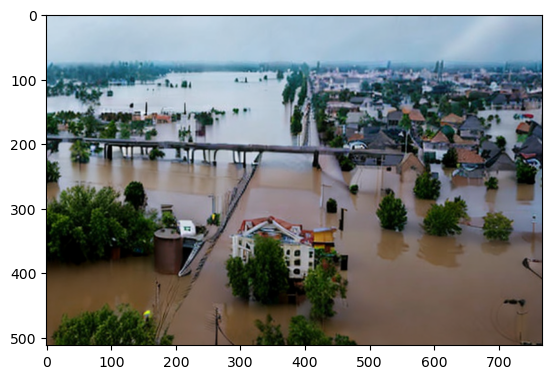

In [482]:
plt.imshow(out_img[-2])

In [ ]:
plt.imshow(out_img[-2])

In [82]:
huggingface-cli

NameError: name 'huggingface' is not defined

In [83]:
from huggingface_hub import notebook_login, Repository

# Login to Hugging Face
notebook_login()

In [115]:
import torch
from transformers import Trainer, TrainingArguments
from huggingface_hub import HfFolder, HfApi

# Assuming your VGG16 model is trained and stored in `custom_vgg16_model`

# Step 2: Save your trained model
model_path = "vgg16"
torch.save(m.model.state_dict(), f"{model_path}/pytorch_model.bin")

# Additional: Save configuration and tokenizer (if any)
# For a custom model, you might need to manually create a config file
# that details your model's architecture and settings.

# Step 3: Authentication (already done manually via `huggingface-cli login`)

# Step 4: Prepare your model for uploading
# This step involves ensuring your model directory has all the necessary files.
# At a minimum, you should have a `config.json` and `pytorch_model.bin`.
# You might need to create a `config.json` manually for a custom model like this.

# Step 5: Use the `transformers` library to upload your model
def push_to_hub(model_directory):
    """Pushes the model and its files to the Hugging Face Hub."""
    # Replace 'your_model_name' with the desired model name on the Hub
    # and 'your_username' with your Hugging Face Hub username
    model_name = "vgg16-flood-detection"
    api = HfApi()
    repo_url = api.create_repo(token=HfFolder.get_token(), repo_id="Ressnn/vgg16-flood-detection", exist_ok=True)
    repo = Repository(local_dir=model_directory, clone_from=repo_url, use_auth_token=True)
    repo.push_to_hub(commit_message="Initial commit")

# Call the function to push your model to the Hub
push_to_hub(model_path)

RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-65c8d0e4-02cc0b046d7ae00d2c05b004;64cbd86a-bbbb-4dd2-a680-b3fce16b8464)

Repository Not Found for url: https://huggingface.co/api/models/Ressnn/vgg16-flood-detection.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.

In [106]:
# print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.2-Product Build 20230613 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
XPU backend version: 1.0  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=/opt/rh/gcc-toolset-11/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=1 -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unk